In [489]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.interpolate import CubicHermiteSpline
from scipy.integrate import quad

In [490]:
class ParametricCubicSpline:
    def __init__(self, x, y, dxdy):
        self.x = x
        self.y = y
        self.spline = CubicHermiteSpline(x, y, dxdy, extrapolate=None)
        self.coefficients = self.spline.c

    def evaluate(self, t_val):
        y_val = self.spline(t_val)
        return y_val
    
    def lengthFunc(self, param):
        derivative = self.spline(param, 1)
        speed = np.linalg.norm(derivative)
        return speed
    
    def arcLength(self):
        # Calculate the arc length using definite integral
        arc_length, _ = quad(self.lengthFunc, self.x[0], self.x[-1])
        return arc_length

    def objective_function(self, t):
        difference_x = self.spline(t) - self.target_x
        difference_y = self.spline(t) - self.target_y
        
        return np.sqrt(difference_x**2 + difference_y**2)

    def calculate_arc_length(self, target_x, target_y):
        self.target_x = target_x
        self.target_y = target_y

        # Minimize the objective function to find the optimal parameter value
        result = minimize_scalar(self.objective_function, method='Golden')

        # Extract the optimal parameter value
        optimal_t = result.x

        # Calculate the arc length using definite integral up to the optimal parameter value
        arc_length, _ = quad(self.lengthFunc, 0, optimal_t)

        return arc_length

    
# Example usage:
x = np.array([0.0, 5.0]) 
y = np.array([0.0, 5.0])  # Control points
dxdy = np.array([0.0, 0.0])


parametric_spline = ParametricCubicSpline(x, y, dxdy)

In [491]:
t_fine = np.linspace(x[0], x[-1], 1000)
y_fine = np.array([parametric_spline.evaluate(t_val) for t_val in t_fine])

for i, coef in enumerate(parametric_spline.coefficients):
    print(f"Coefficients for segment {i}: {coef}")
    

Coefficients for segment 0: [-0.08]
Coefficients for segment 1: [0.6]
Coefficients for segment 2: [0.]
Coefficients for segment 3: [0.]


In [492]:
from random import randint
from sympy import *

a1,a2,a3,a4,x,y,s,ss,s1,s2,s3 = symbols('a1 a2 a3 a4 x y s s^* stilde_1 stilde_2 stilde_3')

In [493]:
fx = a1*s**3+a2*s**2+a3*s+a4
fy = a1*s**3+a2*s**2+a3*s+a4
D = (fx-x)**2 + (fy-y)**2

D_1 = diff(D,s)
D_2 = diff(D_1,s)

In [494]:
P = ((s - s2)*(s - s3))/((s1 - s2)*(s1 - s3))*D.subs(s, s1)+((s - s1)*(s - s3))/((s2 - s1)*(s2 - s3))*D.subs(s, s2)+((s - s1)*(s - s2))/((s3 - s1)*(s3 - s2))*D.subs(s, s3)
P_1 = diff(P, s)
QP = solve(P_1,s)[0]


In [495]:
d = Function('D')(s)
Ptest = ((s - s2)*(s - s3))/((s1 - s2)*(s1 - s3))*d.subs(s, s1)+((s - s1)*(s - s3))/((s2 - s1)*(s2 - s3))*d.subs(s, s2)+((s - s1)*(s - s2))/((s3 - s1)*(s3 - s2))*d.subs(s, s3)
Ptest_1 = diff(Ptest, s)

testsol = solve(Ptest_1,s)
simplify(testsol[0])

(stilde_1**2*D(stilde_2) - stilde_1**2*D(stilde_3) - stilde_2**2*D(stilde_1) + stilde_2**2*D(stilde_3) + stilde_3**2*D(stilde_1) - stilde_3**2*D(stilde_2))/(2*(stilde_1*D(stilde_2) - stilde_1*D(stilde_3) - stilde_2*D(stilde_1) + stilde_2*D(stilde_3) + stilde_3*D(stilde_1) - stilde_3*D(stilde_2)))

In [496]:
simplify(D)

(a1*s**3 + a2*s**2 + a3*s + a4 - x)**2 + (a1*s**3 + a2*s**2 + a3*s + a4 - y)**2

In [497]:
simplify(D_1)

2*(3*a1*s**2 + 2*a2*s + a3)*(2*a1*s**3 + 2*a2*s**2 + 2*a3*s + 2*a4 - x - y)

In [498]:
simplify(D_2)

4*(3*a1*s + a2)*(a1*s**3 + a2*s**2 + a3*s + a4 - x) + 4*(3*a1*s + a2)*(a1*s**3 + a2*s**2 + a3*s + a4 - y) + 4*(3*a1*s**2 + 2*a2*s + a3)**2

In [657]:
import bisect

def setCoefficients(array, coeff):
    coeff['stilde_1'] = array[0]
    coeff['stilde_2'] = array[1]
    coeff['stilde_3'] = array[2]


def insertElement(s_star, array):
    index = bisect.bisect_left(array, s_star)
    array.insert(index, s_star)

def deleteMax(s_star, array, coeff):
    insertElement(s_star, array)
    _, index, _ = max((P.subs(dict(coeff, s=value)), idx, value) for idx, value in enumerate(array))
    array.pop(index)

def returnMin(s_star, array, coeff):
    insertElement(s_star, array)
    _, _, value = min((P.subs(dict(coeff, s=value)), idx, value) for idx, value in enumerate(array))
    return value

def quadratFit(s1, s2, s3, coeff, iterationNumber=3):
    
    s_array = [s1, s2, s3]
    setCoefficients(s_array, coeff)
    
    s_star = QP.subs(coeff)
    print(s_star)
    
    deleteMax(s_star, s_array, coeff)
    setCoefficients(s_array, coeff)
    
    s_star = QP.subs(coeff)
    print(s_star)

    deleteMax(s_star, s_array, coeff)
    setCoefficients(s_array, coeff)
    
    s_star = QP.subs(coeff)
    return returnMin(s_star, s_array, coeff)

In [658]:
def newtonMethod(x0, iterationNumber, coeff_values):
    coeff_values['s'] = x0
    res = 2
    
    for i in range(iterationNumber):
        x1 = x0 - D_1.subs(coeff_values) / D_2.subs(coeff_values)
        coeff_values['s']= x1
     
        res = np.abs(x1 - x0)
        if res <= 0.000001:   # Stop when the result is within the desired tolerance
            return x1, res
        
        x0 = x1
    return x0, res


In [659]:
target_point = np.array([4,6])
QP_coeef_values = {a1: parametric_spline.coefficients[0][0], a2: parametric_spline.coefficients[1][0], a3: parametric_spline.coefficients[2][0], a4: parametric_spline.coefficients[3][0], x: target_point[0], y: target_point[1], s1: 0, s2: 0, s3: 0, s:0}
D_coeff_values = {a1: parametric_spline.coefficients[0][0], a2: parametric_spline.coefficients[1][0], a3: parametric_spline.coefficients[2][0], a4: parametric_spline.coefficients[3][0], x: target_point[0], y: target_point[1], s: 0}

In [660]:
L = parametric_spline.arcLength()
l = parametric_spline.calculate_arc_length(2.5,2.5)

print({f"Length: {L}"}, f"Length to: {l}")
quadraticSol = quadratFit(0,2.5,5,QP_coeef_values)
print(quadraticSol)

{'Length: 5.000000000000002'} Length to: 2.4999999936902033
5.00000000000000
4.99999999999999
[4.99999999999999, 5.00000000000000, 5]
-16.0000000000000


In [661]:
newtonSol, newtonRes = newtonMethod(quadraticSol, 1000, D_coeff_values)
D_coeff_values['s'] = newtonSol
coord_sol = parametric_spline.evaluate(newtonSol)
# print(newtonSol, newtonRes, D.subs(coeff_values))

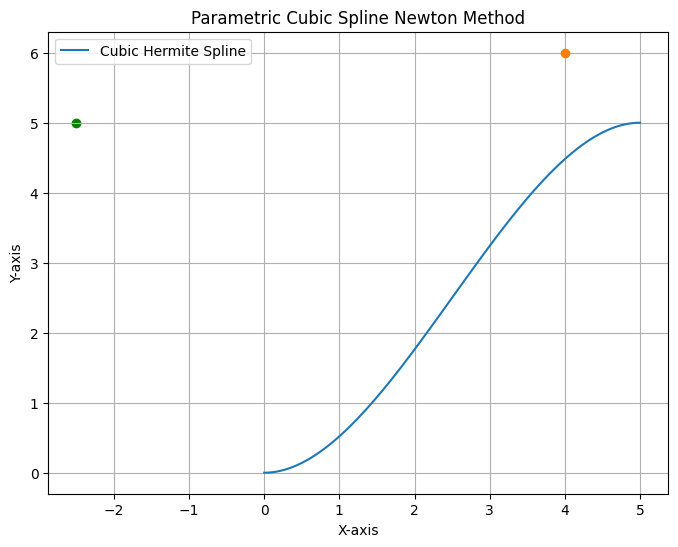

In [662]:
# Plot the original points and the cubic spline
plt.figure(figsize=(8, 6))
plt.plot(t_fine[:], y_fine[:], label='Cubic Hermite Spline')
plt.plot(target_point[0], target_point[1], 'o')
plt.scatter(newtonSol, coord_sol, marker='o', color='green')

plt.title('Parametric Cubic Spline Newton Method')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()